# Machina Labs Take-Home Assignment - Toby Savage

## 1. Problem Statement

The objective of this assignment is to build a machine learning model that can predict the fores experienced by the two robots within the system. Specifically, I am tasked to predict the forces experienced by the tool-tips between the two robots while producing formations from a sheet of metal. One robot (R1) is assigned as the Forming Robot, while the other (R2) is the Forming Robot. Each robot has 3 force scalars, forces in the x, y, and z direction for a total of 6 labels.  <br>

I was provided with three data files (Test1.csv, Test2.csv, and Test4.csv). Each of these files contains thirteen features: the timestamp 't', the Pitch, Roll, and Yaw of R1 and R2, and three coordinates of each Eurler angle for R1 and R2. Each of these test files represents 3 separate sessions of the robots. <br>

The challenge here is to produce a model complex enough to analyze hidden trends within the dataset(s), and provide accurate predictions for the 6 force labels on the tool-tips at any point in time. Understanding how the robots work intuitively (the video was very helpful) is important. 

Throughout this Jupyter Notebook, you will see my whole development process to producing a strong model. At the end of this notebook, you will see uses of XGBoost models and how I evaluated their performances. 

Some assumptions include:
- Each row of data is independent of the next second. This allows me to concatenate all of the 3 datasets together to create a large train, test, and val dataset splits.
- I'm trying to build a model that predicts the forces at any point in time, and not the future "x" many timestamps in the future.
- Each session uses the same two robots.

In [299]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler


## 2. Data Preparation & Analysis

### 2.a Reading and Checking data for Abnormalities

Here, I first read the first session data file to develop an understanding on what the data looks like. (I also used VSCode to view more data points). I check to see if there are any NULL values within the dataset that need to be removed and I look at some simple statistics for each of the features.

In [300]:
df_test_1 = pd.read_csv('data/Test1.csv')
df_test_1.head()

,t,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
0,1636579517,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2023,-179.8798,22.3221,783.1761,-772.5771,-2.326357,9.639795,-32.645949,11.805614,18.656085,-12.831012
1,1636579518,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-2.192611,9.531656,-33.073905,11.697159,18.462518,-12.250218
2,1636579519,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-2.103594,9.776526,-31.435784,11.662171,18.601191,-11.455588
3,1636579520,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-1.869649,9.100982,-31.719140,11.414681,18.489816,-12.538161
4,1636579521,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-2.336206,9.058406,-32.329481,11.223285,17.952984,-10.425429


In [301]:
null_counts = df_test_1.isnull().sum()
print(null_counts)

t          0
a_enc_1    0
b_enc_1    0
c_enc_1    0
x_enc_1    0
y_enc_1    0
z_enc_1    0
a_enc_2    0
b_enc_2    0
c_enc_2    0
x_enc_2    0
y_enc_2    0
z_enc_2    0
fx_1       0
fy_1       0
fz_1       0
fx_2       0
fy_2       0
fz_2       0
dtype: int64


In [302]:
print(f"Number of data points: {len(df_test_1)}")
df_test_1.describe()

Number of data points: 20091


,t,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
count,2.009100e+04,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000,20091.000000
mean,1.636590e+09,-89.243342,0.000876,0.001884,457.838727,196.582466,-65.004211,88.043654,0.001449,-48.584657,456.038225,199.566334,-76.051201,30.842497,90.713730,2518.588040,-29.178737,-103.178406,-740.617396
std,5.800524e+03,7.811876,0.002961,0.007390,197.669145,103.805836,100.980291,22.349876,0.029150,173.319815,202.637762,120.025141,81.255998,681.262919,1192.944410,582.206105,441.132354,729.100519,302.882751
min,1.636580e+09,-90.010338,-0.016044,-0.071996,89.375309,-1.773652,-176.784882,-178.388554,-2.199676,-180.000000,22.318914,-3.800164,-772.577100,-1919.499515,-1841.587267,-77.996067,-1488.688155,-1584.796551,-2315.788958
25%,1.636585e+09,-89.999386,-0.000656,0.000616,290.419367,100.769458,-109.418459,89.995441,-0.001200,-179.998927,288.144090,94.387694,-106.965317,-230.351587,-1176.059427,2447.281778,-256.660575,-773.561600,-811.944934
50%,1.636590e+09,-89.997882,0.000694,0.002700,456.793417,205.300159,-69.102747,89.997237,-0.000319,-179.997522,456.648642,205.461697,-65.262847,16.014140,93.456255,2654.714428,-34.196624,-173.398829,-662.764566
75%,1.636595e+09,-89.996412,0.002148,0.004283,623.566147,290.913058,-33.555666,89.998776,0.000556,179.998508,624.802175,294.557702,-28.547567,366.363106,1299.823169,2854.014779,159.026327,692.334489,-559.024622
max,1.636600e+09,-4.951004,0.023382,0.021594,830.689381,367.268497,895.352800,178.951853,1.164570,180.000000,831.872986,783.177337,-0.681790,1876.367359,2238.735152,3374.798895,1233.724258,1303.750689,-5.323892


### 2.b Graphs

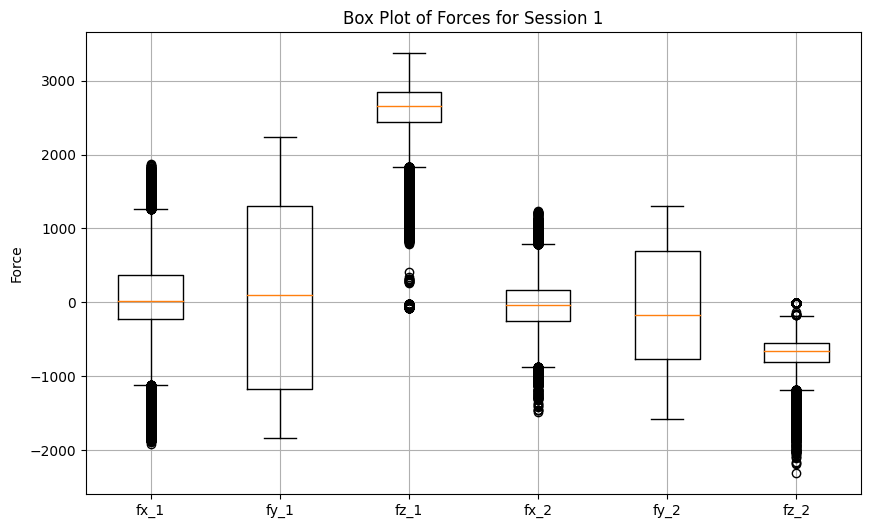

In [282]:
plt.figure(figsize=(10, 6))
plt.boxplot([df_test_1['fx_1'], df_test_1['fy_1'], df_test_1['fz_1'], df_test_1['fx_2'], df_test_1['fy_2'], df_test_1['fz_2']], 
            labels=['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'])

plt.title('Box Plot of Forces for Session 1')
plt.ylabel('Force')
plt.grid(True)
plt.show()

$\textbf{Explanation: }$ Here I plotted a box plot of Session 1 to see what the distribution of the different forces. It appears that there is are many outliers, especially for the forces in the Z axis, the direction perpendicular to the sheet of metal. I am not sure what these outliers are or why they are there, but knowing that these outliers exist will  be usefull deciding on a normalization technique, such as log norm.

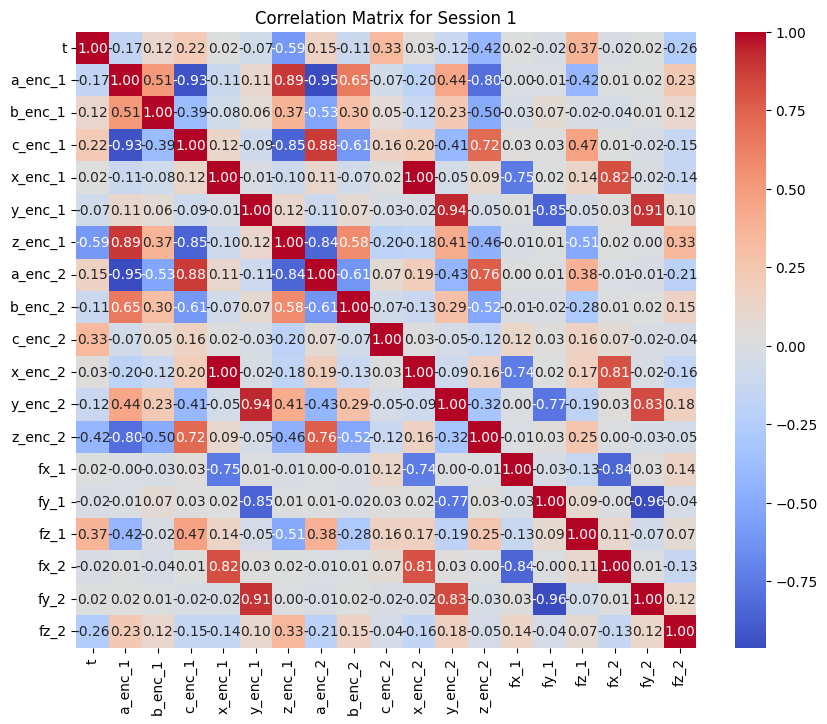

In [283]:
corr_matrix = df_test_1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix for Session 1")
plt.show()

$\textbf{Explanation: }$ This graph shoes the correlation between the features and labels. It is interesting to see that for 'fx_1', the force in the x direction for robot 1, is strongly correlated to 'x_enc_1', the x position of the Euler angle for robot 1, and 'fx_2' the force in the x direction for robot 1, which makes sense given the nature of how the system works. I plot this to see if the data has trends in the correlation between features. At this point, this was a motivation to me to perform some feature selection down the line.

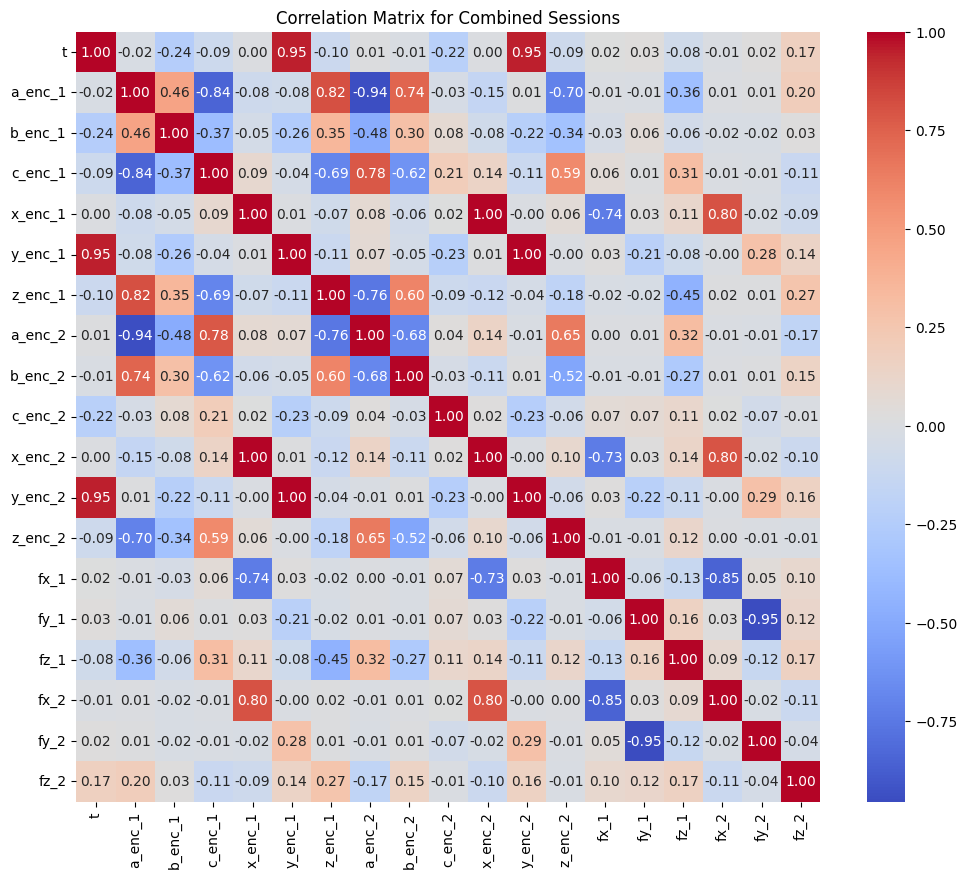

In [284]:
df_test_2 = pd.read_csv('data/Test2.csv')
df_test_3 = pd.read_csv('data/Test4.csv')

combined_df = pd.concat([df_test_1, df_test_2, df_test_3], ignore_index=True)

corr_matrix_combined = combined_df.corr()

plt.figure(figsize=(12, 10))  # Adjust the size as needed
sns.heatmap(corr_matrix_combined, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix for Combined Sessions")
plt.show()

$\textbf{Explanation: }$ Here is a similar correlation matrix, but with sessions 2 and 4 comined. It looks very similar to session 1, indicating that some features rely on others accross all sessions.

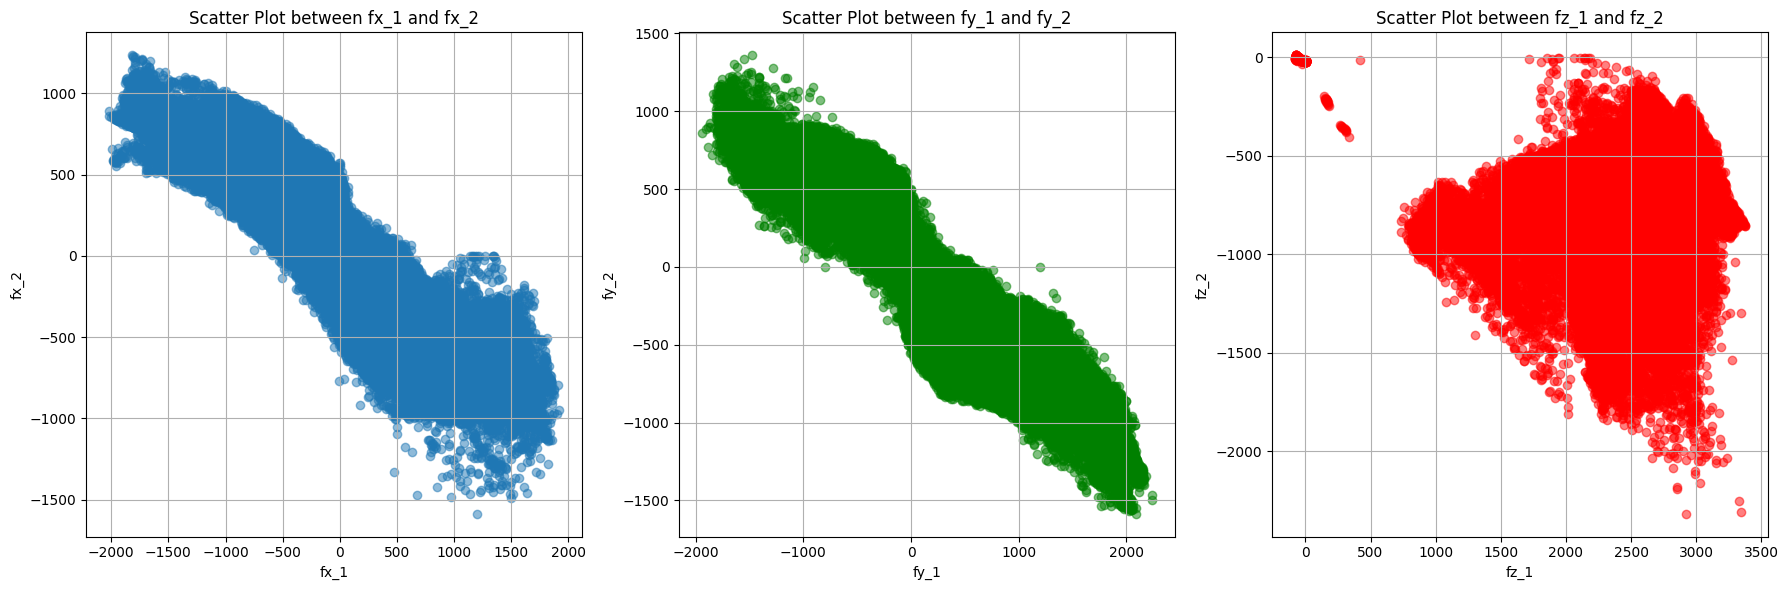

In [285]:
# plot (scatter plot) between fx_1 and fx_2. y, z, ..

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for fx_1 vs fx_2
axes[0].scatter(combined_df['fx_1'], combined_df['fx_2'], alpha=0.5)
axes[0].set_xlabel('fx_1')
axes[0].set_ylabel('fx_2')
axes[0].set_title('Scatter Plot between fx_1 and fx_2')
axes[0].grid(True)

# Scatter plot for fy_1 vs fy_2
axes[1].scatter(combined_df['fy_1'], combined_df['fy_2'], alpha=0.5, color='green')
axes[1].set_xlabel('fy_1')
axes[1].set_ylabel('fy_2')
axes[1].set_title('Scatter Plot between fy_1 and fy_2')
axes[1].grid(True)

# Scatter plot for fz_1 vs fz_2
axes[2].scatter(combined_df['fz_1'], combined_df['fz_2'], alpha=0.5, color='red')
axes[2].set_xlabel('fz_1')
axes[2].set_ylabel('fz_2')
axes[2].set_title('Scatter Plot between fz_1 and fz_2')
axes[2].grid(True)

plt.tight_layout()
plt.show()


$\textbf{Explanation: }$ The three graphs above show the relation between the forces in the X, Y, and Z direction for the two robots. As seen in the correlation matrix and noted above, there is a linear representation between 'fx_1' and 'fx_2', and between 'fy_1' and 'fy_2'. In the Z direction, it looks like there is less of a correlation and linear representation. This could mean that the force in the Z direction of one robot doesn't automatically impact the other while moving.

In [303]:
# df_test_1.keys()
df_test_1['t'] = pd.to_datetime(df_test_1['t'], unit='s')
df_test_1.set_index('t', inplace=True)
print(df_test_1.keys())

Index(['a_enc_1', 'b_enc_1', 'c_enc_1', 'x_enc_1', 'y_enc_1', 'z_enc_1',
       'a_enc_2', 'b_enc_2', 'c_enc_2', 'x_enc_2', 'y_enc_2', 'z_enc_2',
       'fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'],
      dtype='object')


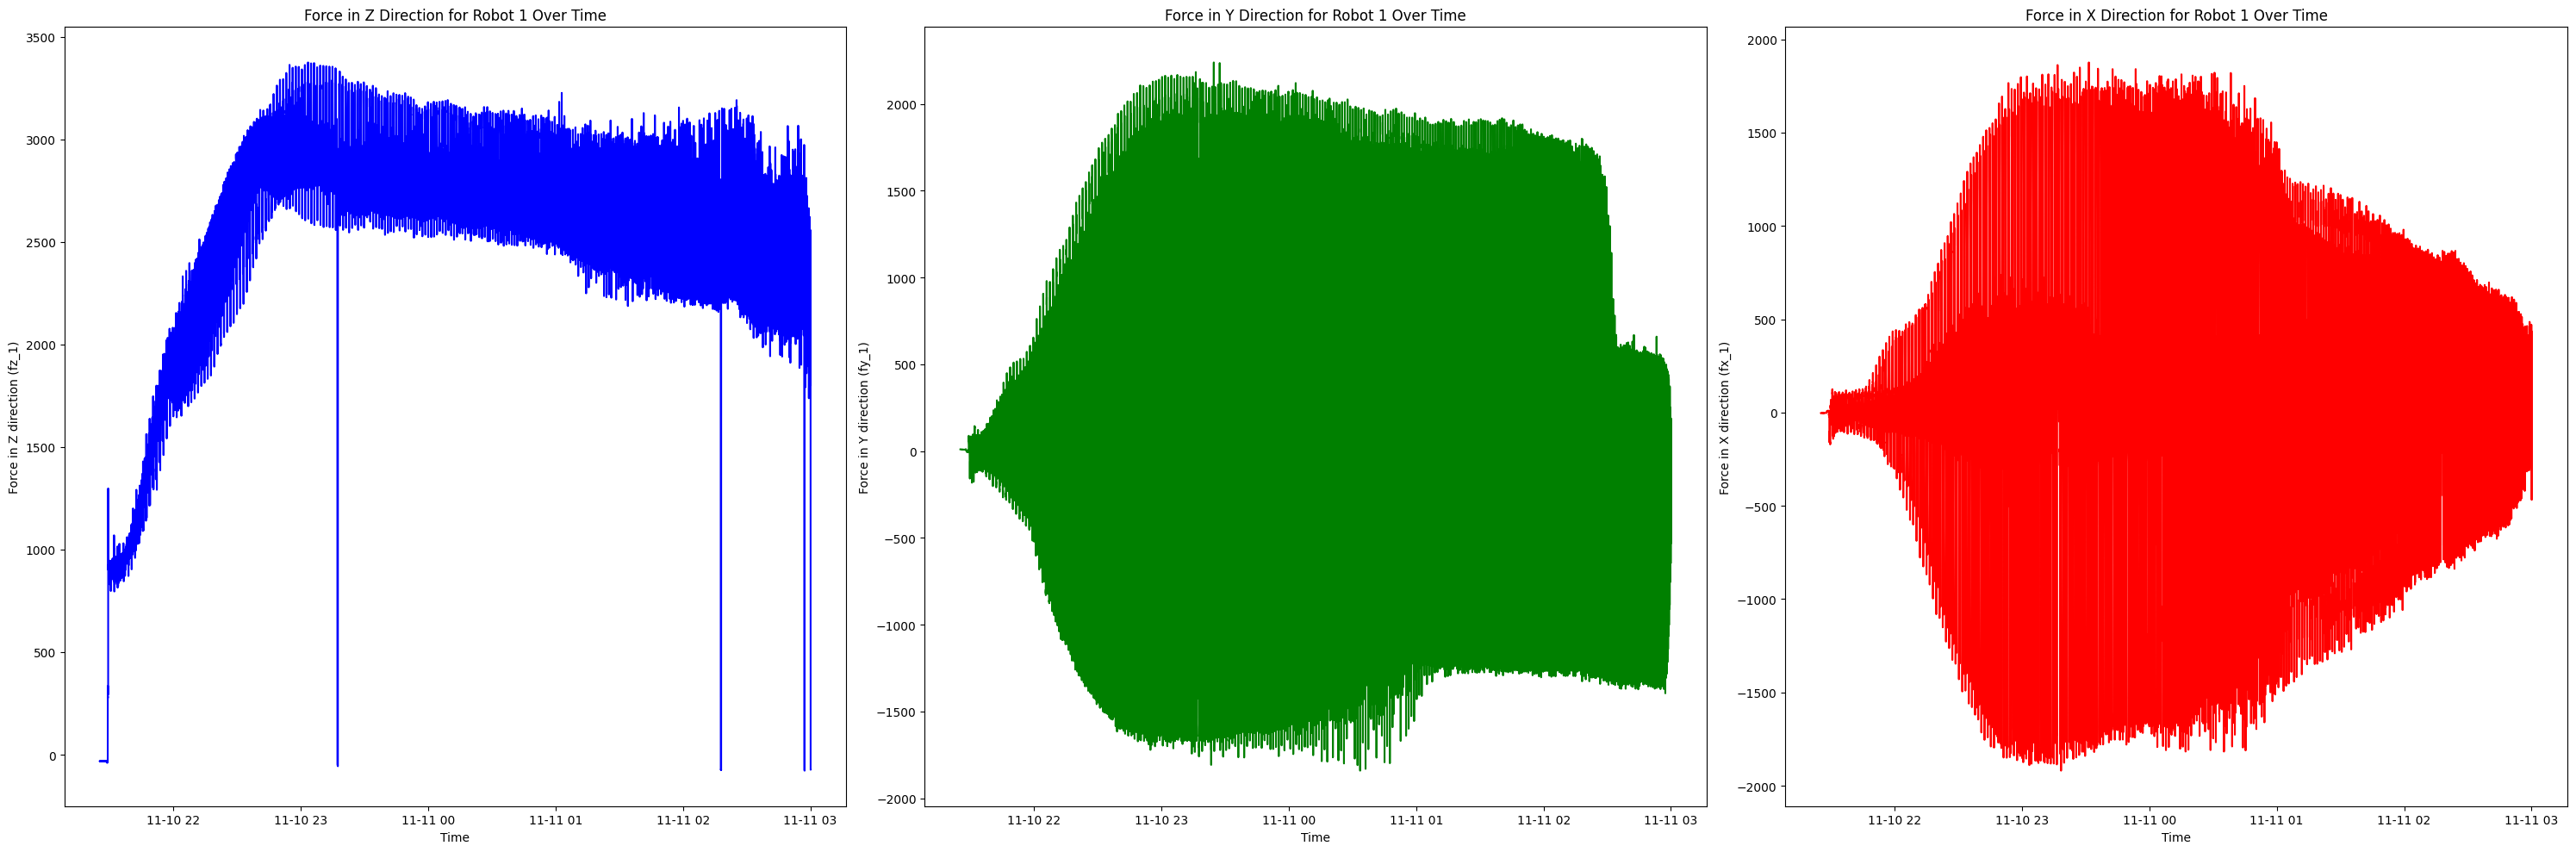

In [309]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].plot(df_test_1.index, df_test_1['fz_1'], color='blue')
axes[0].set_title('Force in Z Direction for Robot 1 Over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Force in Z direction (fz_1)')

axes[1].plot(df_test_1.index, df_test_1['fy_1'], color='green')
axes[1].set_title('Force in Y Direction for Robot 1 Over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Force in Y direction (fy_1)')

axes[2].plot(df_test_1.index, df_test_1['fx_1'], color='red')
axes[2].set_title('Force in X Direction for Robot 1 Over Time')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Force in X direction (fx_1)')

plt.tight_layout()
plt.show()


$\textbf{Explanation:}$ These graphs do not show anything too interesting, as they just show the force experienced in each direction on the tool-tip of robot 1 over time. I was just curious to see what the foreces experienced looked like visually. While there is some linear movement in the Z direction, the Y and Z direction vary greatly.

## 3. Modeling

### 3.a Baseline (Linear Regression)

In [120]:
df_test_1 = pd.read_csv('data/Test1.csv')
X = df_test_1.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
y = df_test_1[['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [78]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [79]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 117033.47323480457


$\textbf{Explanation: }$ Here is a simple Linear Regression model, which was trained on Session 1 data. This was more of an experiment and I wanted to see what the performance would look like. With a high MSE, this tells me I may need to normalize the data to lower the error. It is also possible that the Linear Regression model is not complex enough, so it is unable to map out a linear trajectory of the predictions, especially for 6 labels.

### 3.b Baseline (Sequential Neural Network for Non-Linearity)

In [84]:
model = Sequential()
model.add(Dense(units = 500, input_dim = 13, activation = 'relu'))
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))

model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 500)               7000      
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dense_5 (Dense)             (None, 1)                 501       
                                                                 
Total params: 258,001
Trainable params: 258,001
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

In [86]:
results = model.fit(X_train, 
                   y_train, 
                   epochs = 25, 
                   batch_size = 50, 
                   verbose = 1,
                   validation_split = 0.2)

Epoch 1/25
258/258 [==============================] - 1s 4ms/step - loss: 618594610184192.0000 - val_loss: 1669184.5000
Epoch 2/25
258/258 [==============================] - 1s 3ms/step - loss: 1581120.0000 - val_loss: 1590323.0000
Epoch 3/25
258/258 [==============================] - 1s 5ms/step - loss: 1574455.1250 - val_loss: 1571716.8750
Epoch 4/25
258/258 [==============================] - 1s 3ms/step - loss: 1574992.8750 - val_loss: 1571662.0000
Epoch 5/25
258/258 [==============================] - 1s 4ms/step - loss: 1610282.0000 - val_loss: 1581546.5000
Epoch 6/25
258/258 [==============================] - 1s 4ms/step - loss: 1783157.5000 - val_loss: 1599536.3750
Epoch 7/25
258/258 [==============================] - 1s 4ms/step - loss: 37156974231552.0000 - val_loss: 2993600768.0000
Epoch 8/25
258/258 [==============================] - 1s 4ms/step - loss: 112425176.0000 - val_loss: 1769612.6250
Epoch 9/25
258/258 [==============================] - 1s 4ms/step - loss: 9020303736

$\textbf{Explanation: }$ This is a very simple feed-forward neural network with a ReLU activation function. As a simple experiment, I wanted to see how a NN model would work on the data. Turns out, it performed terribly. This is my realization I need to use a more complex model and incorporate some techniques, such as Feature Selection, Hyperparameter Tuning, and Nromalizing the data.

### 3.c Baseline (Feature Importance Experiment)

In [97]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

feature_names = X_train.columns

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

print(importances_df)

    Feature  Importance
11  y_enc_2    0.558379
10  x_enc_2    0.179976
6   z_enc_1    0.141452
12  z_enc_2    0.056441
4   x_enc_1    0.021139
2   b_enc_1    0.010458
5   y_enc_1    0.005732
0         t    0.005656
9   c_enc_2    0.005409
3   c_enc_1    0.004962
8   b_enc_2    0.004283
1   a_enc_1    0.003965
7   a_enc_2    0.002148


$\textbf{Explanation: }$ Here is a quick show of a Random Forest model showing the feature importances on Session 1. It shows that 'y_enc_2', 'x_enc_2', and 'z_enc_1' are the top 3 most "important" features, the features that have the greates influence on the predictions within the Random Forest regressor model. While this is cool to see, these features might not be important for predicting each of the force directions for the two robots individually, rather in the general prediction. Continuing through this notebook, I aim to effectively trian the model as a whole, while possibly producing 6 separate models with each their own individial important features.

### 3.d Attempting a Multi-Output Regressor model using XGBoost

In [121]:
xgb_regressor = XGBRegressor(objective='reg:squarederror')
multioutput_regressor = MultiOutputRegressor(xgb_regressor)
multioutput_regressor.fit(X_train, y_train)

y_pred = multioutput_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred, multioutput='uniform_average')
print(f'Average Mean Squared Error: {mse}')

mse_each_target = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print(f'MSE for each target: {mse_each_target}')


Average Mean Squared Error: 6020.4072048741045
MSE for each target: [13671.7936755   7796.74489168  2773.22978348  4011.46304259
  3294.97712779  4574.23470821]


In [126]:
xgb_reg = XGBRegressor(random_state=42, reg_alpha=1.0)
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 5949.082343886209


$\textbf{Explanation: }$ Here, I've trained two models using Session 1 data: a multi-output regressor that uses a XGBoost Regressor model, and a regular XGBoost Regressor model. Since I determined I wanted to use a more complex model, XGBoost came to mind to potentially identify hidden trends within the dataset. As you can see, the single XGBoost model (bottom cell) performed better than the series of XGBoost models (top cell). If you scroll up to section 2.b, you can see that the ranges for these forces are quite high, in the thousands. Since these two XGBoost variations performed way better than the Linear Regression and Feed-Forward NN models (lower MSE scores), this could be an indication that I need to normalize the data, to help lower the MSE scores.

### 3.e XGBoost with L1 Regularization, MinMaxScaler Normalization, MultiOutput 

In [147]:
scaler = MinMaxScaler()
df_test_1_scaled = scaler.fit_transform(df_test_1)
df_test_1_scaled = pd.DataFrame(df_test_1_scaled, columns=df_test_1.columns)

X = df_test_1_scaled.iloc[:, :-6]  # Features
Y = df_test_1_scaled.iloc[:, -6:]  # Targets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [149]:
multioutput_regressor = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', reg_alpha=1.0))
multioutput_regressor.fit(X_train, Y_train)
Y_pred = multioutput_regressor.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred, multioutput='uniform_average')
print(f'Average Mean Squared Error: {mse}')
mse_each_target = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
print(f'MSE for each target: {mse_each_target}')

Average Mean Squared Error: 0.0006122700588677138
MSE for each target: [0.0009684  0.00051003 0.00028126 0.00057974 0.00043977 0.00089443]


$\textbf{Explanation: }$ Here I retrained a multi-output regressor using XGBoost Regressor models. This time, however, I used a MinMax Scaling normalization technique, which puts the values of the dataset in a range betwee 0 and 1. As we can see here, the MSE scores are much lower, indicating that the model is able to learn from the training data and generalizes through the test data (80-20 split). I do realize that I am not yet exploring how the data would perform with a validation dataset. These are just steps building up to the final models below. However, we are moving in the right direction!

### 3.f XGBoost with L1 Regularization, Log Normalization, MultiOutput 

In [228]:
df_test_1 = pd.read_csv('data/Test1.csv')

min_value = df_test_1.min().min()
shift = 1 - min_value if min_value <= 0 else 0
df_test_1_shifted = df_test_1 + shift

df_test_1_log_scaled = np.log(df_test_1_shifted)
df_test_1_log_scaled = pd.DataFrame(df_test_1_log_scaled, columns=df_test_1.columns)

X = df_test_1_log_scaled.iloc[:, :-6]  # Features
Y = df_test_1_log_scaled.iloc[:, -6:]  # Targets

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [229]:
# df_test_1_shifted.head()
X_dev, X_test, y_dev, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

In [233]:
multioutput_regressor = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', reg_alpha=1.0))
multioutput_regressor.fit(X_train, y_train)

Y_pred = multioutput_regressor.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred, multioutput='uniform_average')
print(f'Average Mean Squared Error: {mse}')
mse_each_target = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
print(f'MSE for each target: {mse_each_target}')

Average Mean Squared Error: 0.23930491737229662
MSE for each target: [0.24533665 0.6909307  0.03940756 0.07779723 0.25710704 0.12525032]


$\textbf{Explanation: }$ I do the same thing here as above, however this time, I'm using a log normalization technique. I chose to use this normalization since we have a good amount of outliers, based on the graph in section 2.b. Our MSE is not as low, but still performs very well. I will stick with the log normalization technique to in order to reduce the skewness of the outliers within the data and help facilitate linear modeling, making it easier for the models to identify trends in the dataset.

### 3.g XGBoost with Random Forest Feature Importance, Log Normalization, MultiOutput 

In [163]:
labels_list = ['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']
df_test_1 = pd.read_csv('data/Test1.csv')
X = df_test_1.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
top_x_features = 3
chosen_features_dic = {}

# for label in labels_list:
y = df_test_1[labels_list[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

feature_names = X_train.columns

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

print(importances_df.head(top_x_features)['Feature'].tolist())

['x_enc_2', 'y_enc_2', 'x_enc_1']


$\textbf{Explanation: }$ This is my first attempt to identifying the important features using a Random Forest model. This was more of a test to see what the important features would be for 'fx_1', with the intent of looping through all the labels. This is done extensively in the final build of the model. Further down, I only train models and identify their important features using the same models; to stay consistent, rather than mix models.

### 3.h Feature Importance - Hyperparameter Tuning XGBoost

In [239]:
df_test_1 = pd.read_csv('data/Test1.csv')

min_value = df_test_1.min().min()
shift = 1 - min_value if min_value <= 0 else 0
df_test_1_shifted = df_test_1 + shift

df_test_1_log_scaled = np.log(df_test_1_shifted)
df_test_1_log_scaled = pd.DataFrame(df_test_1_log_scaled, columns=df_test_1.columns)

X = df_test_1_log_scaled.iloc[:, :-6]  # Features
Y = df_test_1_log_scaled.iloc[:, -6:]  # Targets

# X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

In [236]:
labels_list = ['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']
df_test_1 = pd.read_csv('data/Test1.csv')
X = df_test_1.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
top_x_features = 3
chosen_features_dic = {}
best_scores = []
best_params = []
best_mses = []
best_r2_scores = []
best_rmses = []

parameters = {'n_estimators': [30, 50, 100], 
              'max_depth': [20, 18, 14],
              'learning_rate': [0.05, 0.1, 0.5]}

for label in labels_list:
    print(f"***** Label: {label} *****")
    
    y = Y[label]
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)    
    
    xgbr = XGBRegressor(random_state=42)
    best_boost_tree = GridSearchCV(xgbr, param_grid=parameters, cv=10)
    best_boost_tree.fit(X_dev, y_dev)

    print("Best Score: ", best_boost_tree.best_score_)
    best_scores.append(best_boost_tree.best_score_)
    print("Best Params: ", best_boost_tree.best_params_)
    best_params = [best_boost_tree.best_params_]

    y_pred = best_boost_tree.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    best_mses.append(mse)
    print("Mean Squared Error: ", mse)
    
    r2 = r2_score(y_test, y_pred)
    best_r2_scores.append(r2)
    print("R^2 Score: ", r2)
    
    rmse = np.sqrt(mse)
    best_rmses.append(rmse)
    print("Root Mean Squared Error: ", rmse)
    
    feat_imps_xgboost = zip(feature_names, best_boost_tree.best_estimator_.feature_importances_)
    feats_xgboost, imps_xgboost = zip(*(sorted(list(filter(lambda x: x[1] !=0, feat_imps_xgboost)), key=lambda x: x[1], reverse=True)))
    chosen_features_dic[label] = feats_xgboost[:3]
    print("The top 3 most important features are: ", feats_xgboost[:3])
    print()

***** Label: fx_1 *****
Best Score:  0.973806360786263
Best Params:  {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
Mean Squared Error:  0.0030776831984799815
R^2 Score:  0.9746011294267373
Root Mean Squared Error:  0.05547687084254105
The top 3 most important features are:  ('x_enc_2', 'y_enc_2', 'z_enc_2')

***** Label: fy_1 *****
Best Score:  0.9959358710738823
Best Params:  {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
Mean Squared Error:  0.0011608738153136774
R^2 Score:  0.9965817461878042
Root Mean Squared Error:  0.03407159836746256
The top 3 most important features are:  ('y_enc_2', 'z_enc_1', 'x_enc_2')

***** Label: fz_1 *****
Best Score:  0.9923069915623731
Best Params:  {'learning_rate': 0.1, 'max_depth': 18, 'n_estimators': 100}
Mean Squared Error:  0.0001108427244133631
R^2 Score:  0.9943523946831807
Root Mean Squared Error:  0.010528187138029181
The top 3 most important features are:  ('z_enc_1', 'z_enc_2', 'x_enc_2')

***** Label: fx_2 ****

$\textbf{Explanation: }$ This is my first successful attempt at training 6 XGBoost models for each of the 6 force labels using log normalization, and hyperparameter tuning. I identify their top 3 important features, best parameters, and compute their MSE and $R^2$ scores using Session 1's dataset. All of these models appeared to perform very well. 

### 3.i Feature Importance - Hyperparameter Tuning Random Forest

In [197]:
parameters = {'n_estimators': [30, 50, 100], 
              'max_depth': [20, 18, 14]}
rf = RandomForestRegressor(random_state=100, oob_score=True, warm_start=True)

best_tree = GridSearchCV(rf, param_grid=parameters)
best_tree.fit(X_dev, y_dev)

print("Best Score: ", best_tree.best_score_)
print("Best Params: ", best_tree.best_params_)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: ", rmse)


Best Score:  0.972704587855338
Best Params:  {'max_depth': 20, 'n_estimators': 100}
Mean Squared Error:  13519.69317962945
Root Mean Squared Error:  116.27421545480085


In [198]:
feat_imps_random_forest = zip(feature_names, best_tree.best_estimator_.feature_importances_)
feats_random_forest, imps_random_forest = zip(*(sorted(list(filter(lambda x: x[1] !=0, feat_imps_random_forest)), key=lambda x: x[1], reverse=True)))

print("The top 3 most important features are: ", feats_random_forest[:3])

The top 3 most important features are:  ('x_enc_2', 'y_enc_2', 'x_enc_1')


In [241]:
df_test_1 = pd.read_csv('data/Test1.csv')

min_value = df_test_1.min().min()
shift = 1 - min_value if min_value <= 0 else 0
df_test_1_shifted = df_test_1 + shift

df_test_1_log_scaled = np.log(df_test_1_shifted)
df_test_1_log_scaled = pd.DataFrame(df_test_1_log_scaled, columns=df_test_1.columns)

X = df_test_1_log_scaled.iloc[:, :-6]  # Features
Y = df_test_1_log_scaled.iloc[:, -6:]  # Targets

In [242]:
parameters = {'n_estimators': [30, 50, 100], 
              'max_depth': [20, 18, 14]}

labels_list = ['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']
df_test_1 = pd.read_csv('data/Test1.csv')
X = df_test_1.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
top_x_features = 3
chosen_features_dic = {}
best_scores = []
best_params = []
best_mses = []
best_r2_scores = []
best_rmses = []

for label in labels_list:
    print(f"***** Label: {label} *****")
    
    y = Y[label]
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)
    
    rf = RandomForestRegressor(random_state=100, oob_score=True, warm_start=True)
    best_tree = GridSearchCV(rf, param_grid=parameters, cv=10)
    best_tree.fit(X_dev, y_dev)

    print("Best Score: ", best_tree.best_score_)
    best_scores_rf.append(best_tree.best_score_)
    print("Best Params: ", best_tree.best_params_)
    best_params_rf.append(best_tree.best_params_)

    y_pred = best_tree.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    best_mses_rf.append(mse)
    print("Mean Squared Error: ", mse)
    
    rmse = np.sqrt(mse)
    best_rmses_rf.append(rmse)
    print("Root Mean Squared Error: ", rmse)

    feat_imps_random_forest = zip(X.columns, best_tree.best_estimator_.feature_importances_)
    feats_random_forest, imps_random_forest = zip(*(sorted(list(filter(lambda x: x[1] !=0, feat_imps_random_forest)), key=lambda x: x[1], reverse=True)))
    chosen_features_rf[label] = feats_random_forest[:3]
    print("The top 3 most important features for", label, "are: ", feats_random_forest[:3])
    print()

***** Label: fx_1 *****
Best Score:  0.9724963079213949
Best Params:  {'max_depth': 18, 'n_estimators': 100}
Mean Squared Error:  0.0032163857131891605
Root Mean Squared Error:  0.056713188176906085
The top 3 most important features for fx_1 are:  ('x_enc_2', 'y_enc_2', 'z_enc_1')

***** Label: fy_1 *****
Best Score:  0.9952889655406978
Best Params:  {'max_depth': 20, 'n_estimators': 100}
Mean Squared Error:  0.0015193484843737735
Root Mean Squared Error:  0.03897882097208397
The top 3 most important features for fy_1 are:  ('y_enc_2', 'z_enc_1', 'x_enc_2')

***** Label: fz_1 *****
Best Score:  0.9902801342837575
Best Params:  {'max_depth': 18, 'n_estimators': 100}
Mean Squared Error:  0.00018061557552180203
Root Mean Squared Error:  0.013439329429767024
The top 3 most important features for fz_1 are:  ('z_enc_1', 'z_enc_2', 'y_enc_2')

***** Label: fx_2 *****
Best Score:  0.9781757798932927
Best Params:  {'max_depth': 20, 'n_estimators': 100}
Mean Squared Error:  0.0008767846707184068

$\textbf{Explanation: }$ Here, I did the saem thing with the Random Forest model as opposed to the XGBoost model, above. The sole reason I tested the Random Forest model was because I wanted to see how the most important features derived compared to those expressed by the XGBoost models for each force label. There were some slight variations, but the important features were quite similar. 

### 3.j Training XGBoost Models (6) Based on Feature Selection

In [243]:
df_session1 = pd.read_csv('data/Test1.csv')
df_session2 = pd.read_csv('data/Test2.csv')
df_session3 = pd.read_csv('data/Test4.csv')

def preprocess(df):
    min_value = df.min().min()
    shift = 1 - min_value if min_value <= 0 else 0
    df_shifted = df + shift
    df_log_scaled = np.log(df_shifted)
    return pd.DataFrame(df_log_scaled, columns=df.columns)

df_session1_processed = preprocess(df_session1)
df_session2_processed = preprocess(df_session2)
df_session3_processed = preprocess(df_session3)

In [244]:
X = df_session1_processed.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
y = df_session1_processed[['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [246]:
labels_list = ['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']
top_x_features = 3
chosen_features_dic = {}
best_scores = []
best_params = []
best_mses = []
best_r2_scores = []
best_rmses = []

parameters = {'n_estimators': [30, 50, 100], 
              'max_depth': [20, 18, 14],
              'learning_rate': [0.05, 0.1, 0.5]}

for label in labels_list:
    print(f"***** Label: {label} *****")
    y_train_new = y_train[label]
    y_val_new = y_val[label]
    
    xgbr = XGBRegressor(random_state=42)
    best_boost_tree = GridSearchCV(xgbr, param_grid=parameters, cv=10)
    best_boost_tree.fit(X_train, y_train_new)
    
    print("Best Score: ", best_boost_tree.best_score_)
    print("Best Score: ", best_boost_tree.best_score_)
    best_scores.append(best_boost_tree.best_score_)
    print("Best Params: ", best_boost_tree.best_params_)
    best_params.append(best_boost_tree.best_params_)
    
    y_val_pred = best_boost_tree.predict(X_val)
    
    mse_val = mean_squared_error(y_val_new, y_val_pred)
    best_mses.append(mse_val)
    print("Validation Mean Squared Error: ", mse_val)
    
    
    r2_val = r2_score(y_val_new, y_val_pred)
    best_r2_scores.append(r2_val)
    print("Validatio R^2 Score: ", r2_val)
    
    rmse_val = np.sqrt(mse_val)
    best_rmses.append(rmse_val)
    print("Root Mean Squared Error: ", rmse_val)
    
    feat_imps_xgboost = zip(feature_names, best_boost_tree.best_estimator_.feature_importances_)
    feats_xgboost, imps_xgboost = zip(*(sorted(list(filter(lambda x: x[1] !=0, feat_imps_xgboost)), key=lambda x: x[1], reverse=True)))
    chosen_features_dic[label] = feats_xgboost[:3]
    print("The top 3 most important features are: ", feats_xgboost[:3])
    print()
    

***** Label: fx_1 *****
Best Score:  0.9734090504795871
Best Score:  0.9734090504795871
Best Params:  {'learning_rate': 0.1, 'max_depth': 18, 'n_estimators': 100}
Validation Mean Squared Error:  0.0033145988018747708
Validatio R^2 Score:  0.9726459610876494
Root Mean Squared Error:  0.05757255250442498
The top 3 most important features are:  ('x_enc_2', 'y_enc_2', 'z_enc_2')

***** Label: fy_1 *****
Best Score:  0.9962424737493254
Best Score:  0.9962424737493254
Best Params:  {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
Validation Mean Squared Error:  0.0011196144671563298
Validatio R^2 Score:  0.9967032365016238
Root Mean Squared Error:  0.03346064056703532
The top 3 most important features are:  ('y_enc_2', 'z_enc_1', 'x_enc_2')

***** Label: fz_1 *****
Best Score:  0.9928863411483888
Best Score:  0.9928863411483888
Best Params:  {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
Validation Mean Squared Error:  9.590332790201365e-05
Validatio R^2 Score:  0.9

In [248]:
trained_models_top_features = {}

for idx, label in enumerate(labels_list):
    print(f"***** Retraining Model for Label: {label} with Top 3 Features *****")

    top_features = chosen_features_dic[label]
    X_train_top_features = X_train[list(top_features)]
    X_val_top_features = X_val[list(top_features)]

    best_hyperparams = best_params[idx]

    xgbr_top_features = XGBRegressor(random_state=42, **best_hyperparams)
    xgbr_top_features.fit(X_train_top_features, y_train[label])

    y_val_pred = xgbr_top_features.predict(X_val_top_features)
    mse_val = mean_squared_error(y_val[label], y_val_pred)
    r2_val = r2_score(y_val[label], y_val_pred)

    print("Validation MSE: ", mse_val)
    print("Validation R^2 Score: ", r2_val)
    trained_models_top_features[label] = xgbr_top_features
    print("Model retrained with top 3 features: ", top_features)
    print()


***** Retraining Model for Label: fx_1 with Top 3 Features *****
Validation MSE:  0.011000401378161235
Validation R^2 Score:  0.9092181511742832
Model retrained with top 3 features:  ('x_enc_2', 'y_enc_2', 'z_enc_2')

***** Retraining Model for Label: fy_1 with Top 3 Features *****
Validation MSE:  0.004045198874853413
Validation R^2 Score:  0.9880886998288252
Model retrained with top 3 features:  ('y_enc_2', 'z_enc_1', 'x_enc_2')

***** Retraining Model for Label: fz_1 with Top 3 Features *****
Validation MSE:  0.0009261462373446011
Validation R^2 Score:  0.9528114412392684
Model retrained with top 3 features:  ('z_enc_1', 'z_enc_2', 'y_enc_2')

***** Retraining Model for Label: fx_2 with Top 3 Features *****
Validation MSE:  0.0034695200510010973
Validation R^2 Score:  0.9136309263491995
Model retrained with top 3 features:  ('x_enc_2', 'y_enc_2', 'x_enc_1')

***** Retraining Model for Label: fy_2 with Top 3 Features *****
Validation MSE:  0.0023027082662096365
Validation R^2 Score: 

In [253]:
def evaluate_models(models, models_features, X_full, y_test):
    for label in labels_list:
        print(f"Evaluating Model for {label} on Test Data")

        top_features = list(models_features[label])
        X_test = X_full[top_features]

        model = models[label]
        y_test_label = y_test[label]

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test_label, y_pred)
        r2 = r2_score(y_test_label, y_pred)

        print(f"Test MSE for {label}: {mse}")
        print(f"Test R^2 Score for {label}: {r2}")
        print()

X_test2_full = df_session2_processed.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
y_test2 = df_session2_processed[['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']]

X_test3_full = df_session3_processed.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
y_test3 = df_session3_processed[['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']]

print("Evaluating on Session 2:")
evaluate_models(trained_models_top_features, chosen_features_dic, X_test2_full, y_test2)
print()


print("Evaluating on Session 3:")
evaluate_models(trained_models_top_features, chosen_features_dic, X_test3_full, y_test3)


Evaluating on Session 2:
Evaluating Model for fx_1 on Test Data
Test MSE for fx_1: 0.2013587687084773
Test R^2 Score for fx_1: -0.038218962833661774

Evaluating Model for fy_1 on Test Data
Test MSE for fy_1: 0.8098778508639753
Test R^2 Score for fy_1: -0.7294425685591863

Evaluating Model for fz_1 on Test Data
Test MSE for fz_1: 0.40618509972665956
Test R^2 Score for fz_1: -23.85979342094823

Evaluating Model for fx_2 on Test Data
Test MSE for fx_2: 0.07290791012753059
Test R^2 Score for fx_2: -0.6867837040622089

Evaluating Model for fy_2 on Test Data
Test MSE for fy_2: 0.26685500367480613
Test R^2 Score for fy_2: -0.9865206356942304

Evaluating Model for fz_2 on Test Data
Test MSE for fz_2: 0.27592329952922523
Test R^2 Score for fz_2: -2.739807114351836


Evaluating on Session 3:
Evaluating Model for fx_1 on Test Data
Test MSE for fx_1: 0.09196215087108991
Test R^2 Score for fx_1: 0.4033605907127691

Evaluating Model for fy_1 on Test Data
Test MSE for fy_1: 1.2067001791726004
Test R^

$\textbf{Explanation: }$ In this scenario, it contains the entire flow of reading the data, log normalizing, identifying the important features, and re-training the models based on their respected important features. The models performed poorly due to the way I split my dataset. Essentially, I did an 80:20 percent split of Session 1, where Session 1 is 80% training and 20% validation. Sessions 2 and 3 are combined as a test set. This is not ideal since the model is trained on a limited amount of data on a specific session. Thus, unable to generalize to Sessions 2 and 3. Below are my Final Model versions using a more proper data split.

## 4. Final Models and Evaluations

This section contains my final models. You may run these cells individually if you wish. The second variation will take some time to run. These models are trained using the concatenation of the 3 sessioned datasets, while using most techniques shown above. <br>

Models included:
- 4.a Single XGBoost Model
- 4.b Multiple (6) XGBoost Models (Basically L1)

### 4.a Single XGBoost Model with Concatenated Datasets

In [310]:
df_session1 = pd.read_csv('data/Test1.csv')
df_session2 = pd.read_csv('data/Test2.csv')
df_session3 = pd.read_csv('data/Test4.csv')

combined_df = pd.concat([df_session1, df_session2, df_session3], ignore_index=True)

def preprocess(df):
    min_value = df.min().min()
    shift = 1 - min_value if min_value <= 0 else 0
    df_shifted = df + shift
    df_log_scaled = np.log(df_shifted)
    return pd.DataFrame(df_log_scaled, columns=df.columns)

processed_df = preprocess(combined_df)


In [311]:
X = processed_df.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
y = processed_df[['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [312]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [313]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred, multioutput='raw_values')
    r2 = r2_score(y, y_pred, multioutput='raw_values')
    return mse, r2

mse_val, r2_val = evaluate_model(model, X_val, y_val)
print("Validation MSE: ", mse_val)
print("Validation R^2 Score: ", r2_val)
print()

mse_test, r2_test = evaluate_model(model, X_test, y_test)
print("Test MSE: ", mse_test)
print("Test R^2 Score: ", r2_test)


Validation MSE:  [0.00669661 0.00317789 0.00016544 0.00166701 0.00165941 0.0046542 ]
Validation R^2 Score:  [0.95056686 0.9893751  0.99053355 0.95341387 0.98416722 0.89353659]

Test MSE:  [0.00687223 0.00317896 0.00020057 0.00168362 0.00174602 0.0033007 ]
Test R^2 Score:  [0.95068137 0.98927176 0.98868424 0.95295684 0.98321846 0.91205396]


In [318]:
print("Validation MSE Average: ", np.average(mse_val))
print("Validation R^2 Average: ", np.average(r2_val))
print()

print("Test MSE Average: ", np.average(mse_test))
print("Test R^2 Average: ", np.average(r2_test))

Validation MSE Average:  0.003003427673421058
Validation R^2 Average:  0.9602655312848826

Test MSE Average:  0.0028303487590130715
Test R^2 Average:  0.9628111060856545


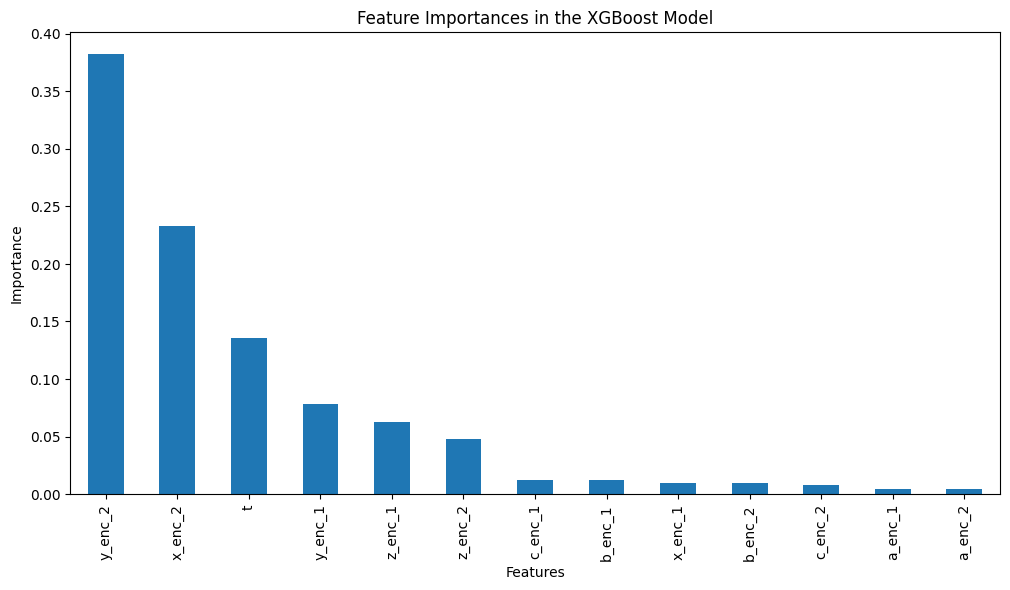

In [314]:
feature_importances = model.feature_importances_
importances_series = pd.Series(feature_importances, index=X_train.columns)
sorted_importances = importances_series.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sorted_importances.plot(kind='bar')
plt.title("Feature Importances in the XGBoost Model")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

$\textbf{Explanation: }$ For this single XGBoost model predicting all 6 feature values at any point in time, I concatenate all 3 sessions into one larger dataset. Using a random split, I dedicate 40% to my training dataset, 30% to my validation dataset, and 30% to my testing set. As we can see, this single XGBoost model performes way better than the previous training split. As you can see, amongst the 6 models per respected force feature, the average MSE and R^2 scores are fairly similar, indicating that the single XGBoost model is fitting well to the concatenated dataset. We can also see the simple box plot of the most important features. This differs from the important features for the previous XGBoost models because the timestamp feature 't' is present as a top 3. This makes sense since I'm assuming that at any timestamp t, the Euler angles, foreces, and positions differ depending on the different sessions. 

### 4.b Multiple (6) Models

In [262]:
df_session1 = pd.read_csv('data/Test1.csv')
df_session2 = pd.read_csv('data/Test2.csv')
df_session3 = pd.read_csv('data/Test4.csv')

combined_df = pd.concat([df_session1, df_session2, df_session3], ignore_index=True)

def preprocess(df):
    min_value = df.min().min()
    shift = 1 - min_value if min_value <= 0 else 0
    df_shifted = df + shift
    df_log_scaled = np.log(df_shifted)
    return pd.DataFrame(df_log_scaled, columns=df.columns)

processed_df = preprocess(combined_df)

X = processed_df.drop(['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2'], axis=1)
y = processed_df[['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [263]:
labels_list = ['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']
top_x_features = 3
chosen_features_dic = {}
best_scores = []
best_params = []
best_mses = []
best_r2_scores = []
best_rmses = []

parameters = {'n_estimators': [30, 50, 100], 
              'max_depth': [20, 18, 14],
              'learning_rate': [0.05, 0.1, 0.5]}

for label in labels_list:
    print(f"***** Label: {label} *****")
    y_train_new = y_train[label]
    y_val_new = y_val[label]
    
    xgbr = XGBRegressor(random_state=42)
    best_boost_tree = GridSearchCV(xgbr, param_grid=parameters, cv=10)
    best_boost_tree.fit(X_train, y_train_new)
    
    print("Best Score: ", best_boost_tree.best_score_)
    print("Best Score: ", best_boost_tree.best_score_)
    best_scores.append(best_boost_tree.best_score_)
    print("Best Params: ", best_boost_tree.best_params_)
    best_params.append(best_boost_tree.best_params_)
    
    y_val_pred = best_boost_tree.predict(X_val)
    
    mse_val = mean_squared_error(y_val_new, y_val_pred)
    best_mses.append(mse_val)
    print("Validation Mean Squared Error: ", mse_val)
    
    
    r2_val = r2_score(y_val_new, y_val_pred)
    best_r2_scores.append(r2_val)
    print("Validatio R^2 Score: ", r2_val)
    
    rmse_val = np.sqrt(mse_val)
    best_rmses.append(rmse_val)
    print("Root Mean Squared Error: ", rmse_val)
    
    feat_imps_xgboost = zip(feature_names, best_boost_tree.best_estimator_.feature_importances_)
    feats_xgboost, imps_xgboost = zip(*(sorted(list(filter(lambda x: x[1] !=0, feat_imps_xgboost)), key=lambda x: x[1], reverse=True)))
    chosen_features_dic[label] = feats_xgboost[:3]
    print("The top 3 most important features are: ", feats_xgboost[:3])
    print()
    

***** Label: fx_1 *****
Best Score:  0.9672523750634866
Best Score:  0.9672523750634866
Best Params:  {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
Validation Mean Squared Error:  0.004230795726069062
Validatio R^2 Score:  0.968769068594657
Root Mean Squared Error:  0.06504456722947015
The top 3 most important features are:  ('x_enc_2', 'y_enc_2', 'z_enc_2')

***** Label: fy_1 *****
Best Score:  0.994394983359373
Best Score:  0.994394983359373
Best Params:  {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
Validation Mean Squared Error:  0.0016327239529486893
Validatio R^2 Score:  0.9945411705623608
Root Mean Squared Error:  0.04040697901289689
The top 3 most important features are:  ('y_enc_2', 't', 'z_enc_1')

***** Label: fz_1 *****
Best Score:  0.9914811946247699
Best Score:  0.9914811946247699
Best Params:  {'learning_rate': 0.1, 'max_depth': 18, 'n_estimators': 100}
Validation Mean Squared Error:  0.00013554097137172987
Validatio R^2 Score:  0.9922443772

In [264]:
trained_models_top_features = {}

for idx, label in enumerate(labels_list):
    print(f"***** Retraining Model for Label: {label} with Top 3 Features *****")

    top_features = chosen_features_dic[label]
    X_train_top_features = X_train[list(top_features)]
    y_train_label = y_train[label]

    best_hyperparams = best_params[idx]

    xgbr_top_features = XGBRegressor(random_state=42, **best_hyperparams)
    xgbr_top_features.fit(X_train_top_features, y_train_label)

    X_val_top_features = X_val[list(top_features)]
    y_val_pred = xgbr_top_features.predict(X_val_top_features)
    mse_val = mean_squared_error(y_val[label], y_val_pred)
    r2_val = r2_score(y_val[label], y_val_pred)

    print("Validation MSE: ", mse_val)
    print("Validation R^2 Score: ", r2_val)

    trained_models_top_features[label] = xgbr_top_features
    print("Model retrained with top 3 features: ", top_features)
    print()


***** Retraining Model for Label: fx_1 with Top 3 Features *****
Validation MSE:  0.012643977892345747
Validation R^2 Score:  0.9066645539482429
Model retrained with top 3 features:  ('x_enc_2', 'y_enc_2', 'z_enc_2')

***** Retraining Model for Label: fy_1 with Top 3 Features *****
Validation MSE:  0.0054132197945180646
Validation R^2 Score:  0.9819015066733359
Model retrained with top 3 features:  ('y_enc_2', 't', 'z_enc_1')

***** Retraining Model for Label: fz_1 with Top 3 Features *****
Validation MSE:  0.0007417361521647808
Validation R^2 Score:  0.9575580303992199
Model retrained with top 3 features:  ('z_enc_1', 'z_enc_2', 'y_enc_2')

***** Retraining Model for Label: fx_2 with Top 3 Features *****
Validation MSE:  0.003264218427925422
Validation R^2 Score:  0.908778602126264
Model retrained with top 3 features:  ('x_enc_2', 'y_enc_2', 'x_enc_1')

***** Retraining Model for Label: fy_2 with Top 3 Features *****
Validation MSE:  0.004690155360018027
Validation R^2 Score:  0.95525

In [271]:
def evaluate_model(model, X_test, y_test_label):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test_label, y_pred)
    r2 = r2_score(y_test_label, y_pred)
    return mse, r2

validation_mse = []
validation_r2 = []
test_mse = []
test_r2 = []

for label in labels_list:
    model = trained_models_top_features[label]
    X_val_top_features = X_val[list(chosen_features_dic[label])]
    y_val_label = y_val[label]

    mse, r2 = evaluate_model(model, X_val_top_features, y_val_label)
    validation_mse.append(mse)
    validation_r2.append(r2)

for label in labels_list:
    model = trained_models_top_features[label]
    X_test_top_features = X_test[list(chosen_features_dic[label])]
    y_test_label = y_test[label]

    mse, r2 = evaluate_model(model, X_test_top_features, y_test_label)
    test_mse.append(mse)
    test_r2.append(r2)


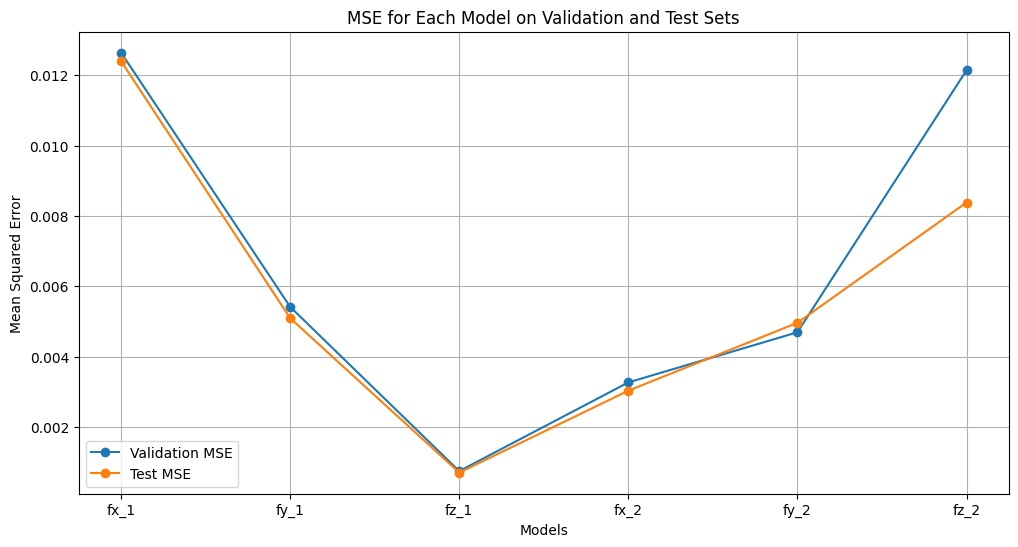

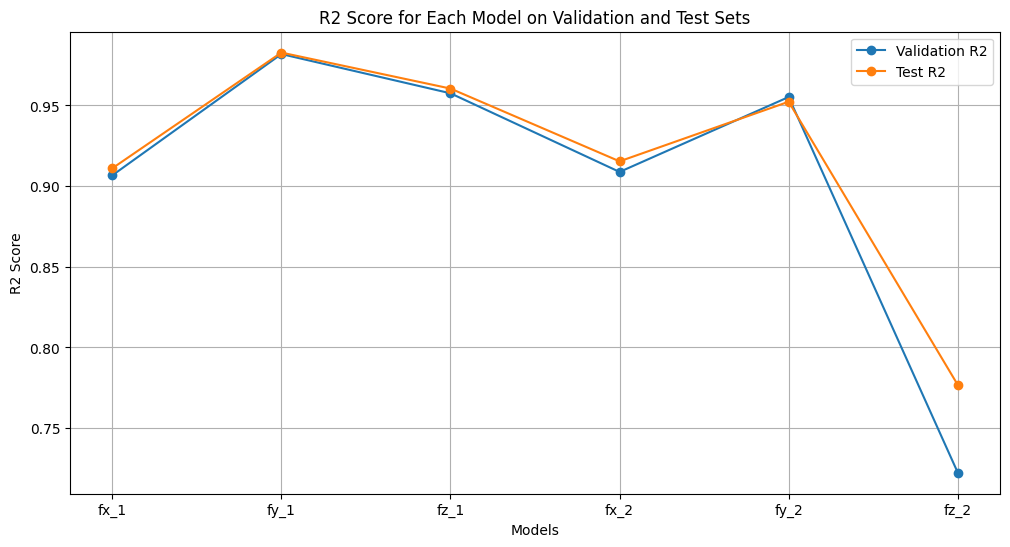

In [273]:
import matplotlib.pyplot as plt

labels = ['fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2']

plt.figure(figsize=(12, 6))
plt.plot(labels, validation_mse, marker='o', label='Validation MSE')
plt.plot(labels, test_mse, marker='o', label='Test MSE')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Each Model on Validation and Test Sets')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(labels, validation_r2, marker='o', label='Validation R2')
plt.plot(labels, test_r2, marker='o', label='Test R2')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Score for Each Model on Validation and Test Sets')
plt.legend()
plt.grid(True)
plt.show()


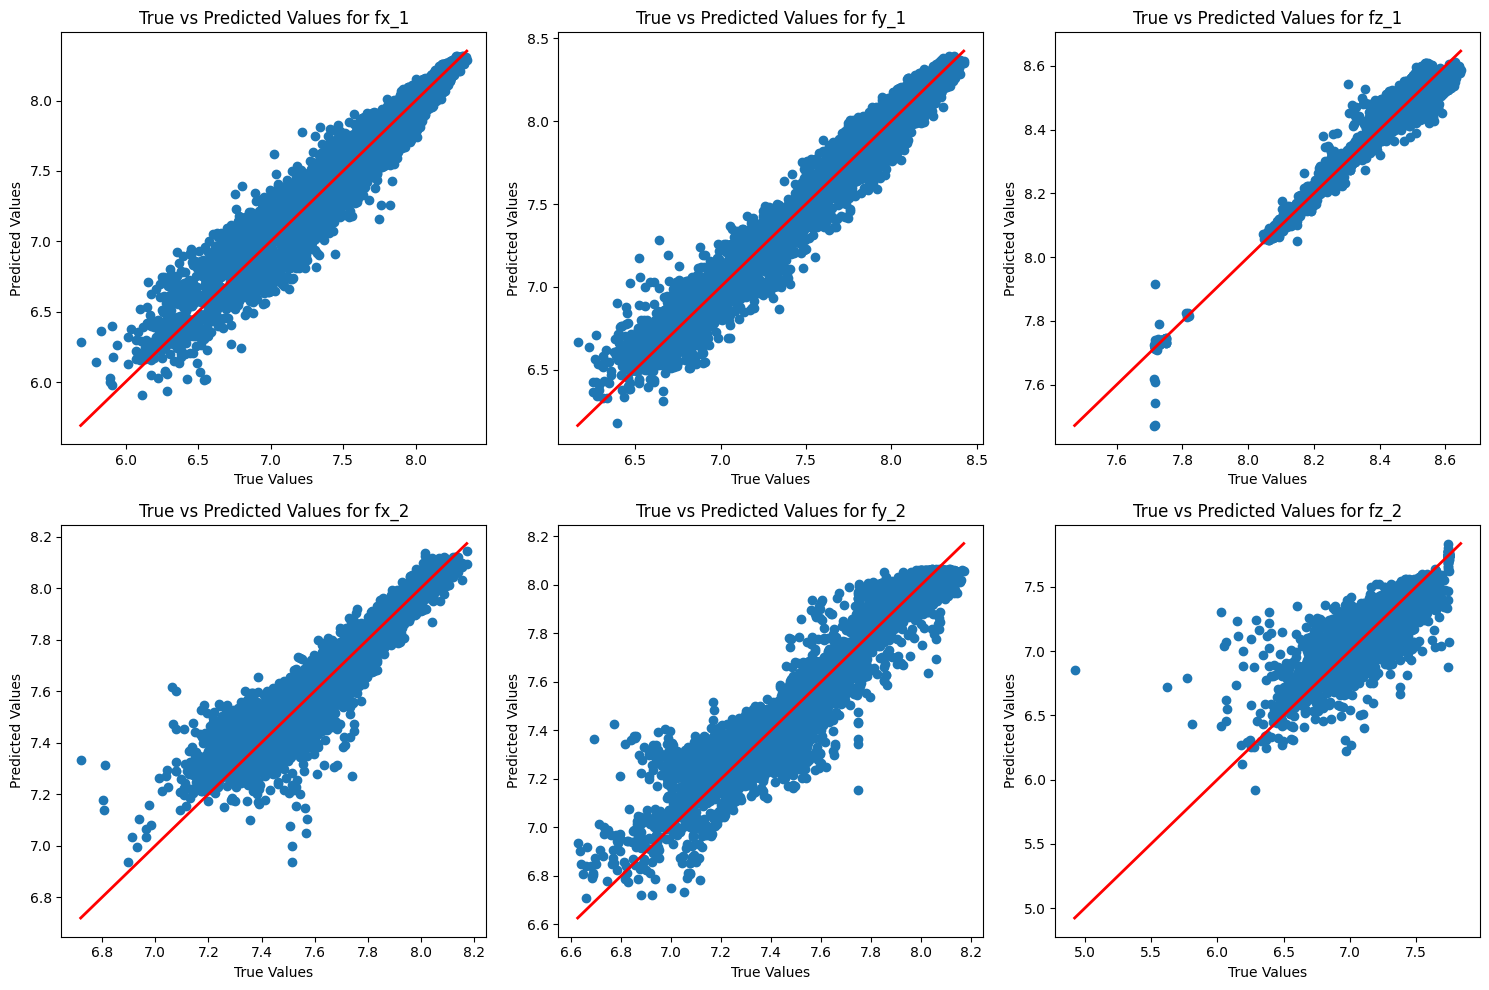

In [276]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()  # for easy indexing

for i, label in enumerate(labels_list):
    axes[i].scatter(y_test[label], predictions[label])
    min_val = min(y_test[label].min(), predictions[label].min())
    max_val = max(y_test[label].max(), predictions[label].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2)
    axes[i].set_xlabel('True Values')
    axes[i].set_ylabel('Predicted Values')
    axes[i].set_title(f'True vs Predicted Values for {label}')

plt.tight_layout()
plt.show()


$\textbf{Explanation: }$ In this section, I used the techniques I showed and explained above in section 3. This prediction uses 6 separate XGBoost regressor models, where each is predicting a single force value in a particular direction, which mimics a L1 regularization. Similar to section 3, I also use log normalization and hyperparameter tuning to get the best-fitting trees and most important features. I then retrain each of the 6 models. I plotted two line graphs above for the validation and test MSE and $R^2$ scores for all 6 models. Aside from the 'fz_2' model, the MSE and $R^2$ scores between validation and test align together well, which is indicating that each model is fitting well to the data. The low MSE scores explain that there is very little difference between the predicted and actual values of the label, and the high R^2 scores indicate that the models are able to explain the variations of the the dependent variables in the data.<br>

Additionally, I plotted the linear representation of the True and PRedicted values for each of the models. What is interesting is the two forces in the Z direction of both robots (top right and bottom right). For robot 1, 'fz_1', we have outliers around 7.75, no data between 7.8-8, and then a bunch of data from 8-8.6. I'm not sure why these outlers are there, maybe these are pauses in the robot's movements. For root 2, 'fz_2', There is a bit of a larger clump with random outliers. Based on the difference between and lower MSE and $R^2$ scores, predictions for fz_2 are not as strong. Some in-depth data cleaning or additional data may be necessary to better predict the forces in the Z direction. Especially for robot 2.

## Conclusion

Based on the two final models above, I'd argue that the first model (4.a) performs better the second (4.b). This is because you can see the validation and test scores for MSE and $R^2$ are higher for the first model than the second. This is especially true for the force of the two robots in the Z axis. I chose to use an XGBoost model as a result to my experimentation with simpler and like models. The simpler models, such as Linear Regression, while a baseline, did not perform well on what I expected to be a complex dataset. XGBoost model did a fairly good job in identifying important features within the dataset. For example, it would make sense that 'fz_1' predictions are largely impacted by the Euler angles of both robots in the Z direction. One CON of using a XGBoost, however, is that the relations are sometimes hidden. For simpler models, if explored further, you can directly view the relations between different features. But because were working with a complex dataset, XGBoost works well with non-linearity, as we have discovered while progressing through this notebook. <br>

Given more time to work on this assignment, I would explore further models and techniques, as well as more in-depth data analysis. This was a fun problem!